In [1]:
#Aalysis of outputs with SSH, SST (unfiltered), and (u,v) as inputs. 
#Include: snapshot plots, power spectra. Different methods for computing power spectra are experimented on.
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold
from copy import deepcopy
from scipy.stats import pearsonr
from pathlib import Path
import numpy.fft as fft
import matplotlib.patches as patches
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
if 'C:/Users/jinkou/Nextcloud/hw_pythonfuncs' not in sys.path:   
    sys.path.append('C:/Users/jinkou/Nextcloud/hw_pythonfuncs' )
import hwm0 as m0
import hwffts as hwfft
import colorcet as cc

vel_cmap  = cc.cm.CET_CBD1
TOTssh_cmap =  cc.cm.CET_D2
ITssh_cmap  = cc.cm.CET_D1A
sst_cmap = cc.cm.linear_bmy_10_95_c78
vort_cmap =  cc.cm.CET_D3

bottom_slice = slice(0,256)
mid_slice = slice(232, 488)
top_slice = slice(464, 720)

def corr(data, mod):
    return pearsonr(data.flatten(), mod.flatten())[0]
def L2_R(data,mod):
    return R2(data.flatten(), mod.flatten())
def performance_metrics(data, mod):
    return corr(data, mod), L2_R(data,mod)

modeloutput_dir = '../model_outputs/'
npfile = np.load(modeloutput_dir+'HUTcombs_UNet.npz')

snap_index = 100
colorlist=['#DDAA33','#004488','#BB5566']
figfolder = '../hwfigures/'
iplotend = 90

In [2]:
T_out_mod = npfile['arr_0'] #Dimension: time - channel - height - width (150-2-720-256) 
H_out_mod = npfile['arr_1']
U_out_mod = npfile['arr_2'] 
HT_out_mod = npfile['arr_3']
TU_out_mod = npfile['arr_4']
HU_out_mod = npfile['arr_5']
HUT_out_mod = npfile['arr_6']
Truth_test = npfile['arr_7']

In [3]:
nt, _, ny, nx= np.shape(HUT_out_mod)

dx = 4000 #Grid resolution is 4 km
Lx = nx*dx
Ly = ny*dx
print (Ly)

#axes used for plotting only
x_axis = np.arange(0, Lx, dx)/1000 # in km
y_axis = np.arange(0, Ly, dx)/1000
extent = [np.min(x_axis), np.max(x_axis), np.min(y_axis), np.max(y_axis)]

2880000


In [4]:
HUT_wave = HUT_out_mod[snap_index,0,:, : ]
H_wave = H_out_mod[snap_index,0,:, : ]
true_wave = Truth_test[snap_index,0,:, : ]

ITm = np.max(np.abs(true_wave))
ITclims = (-ITm, ITm)

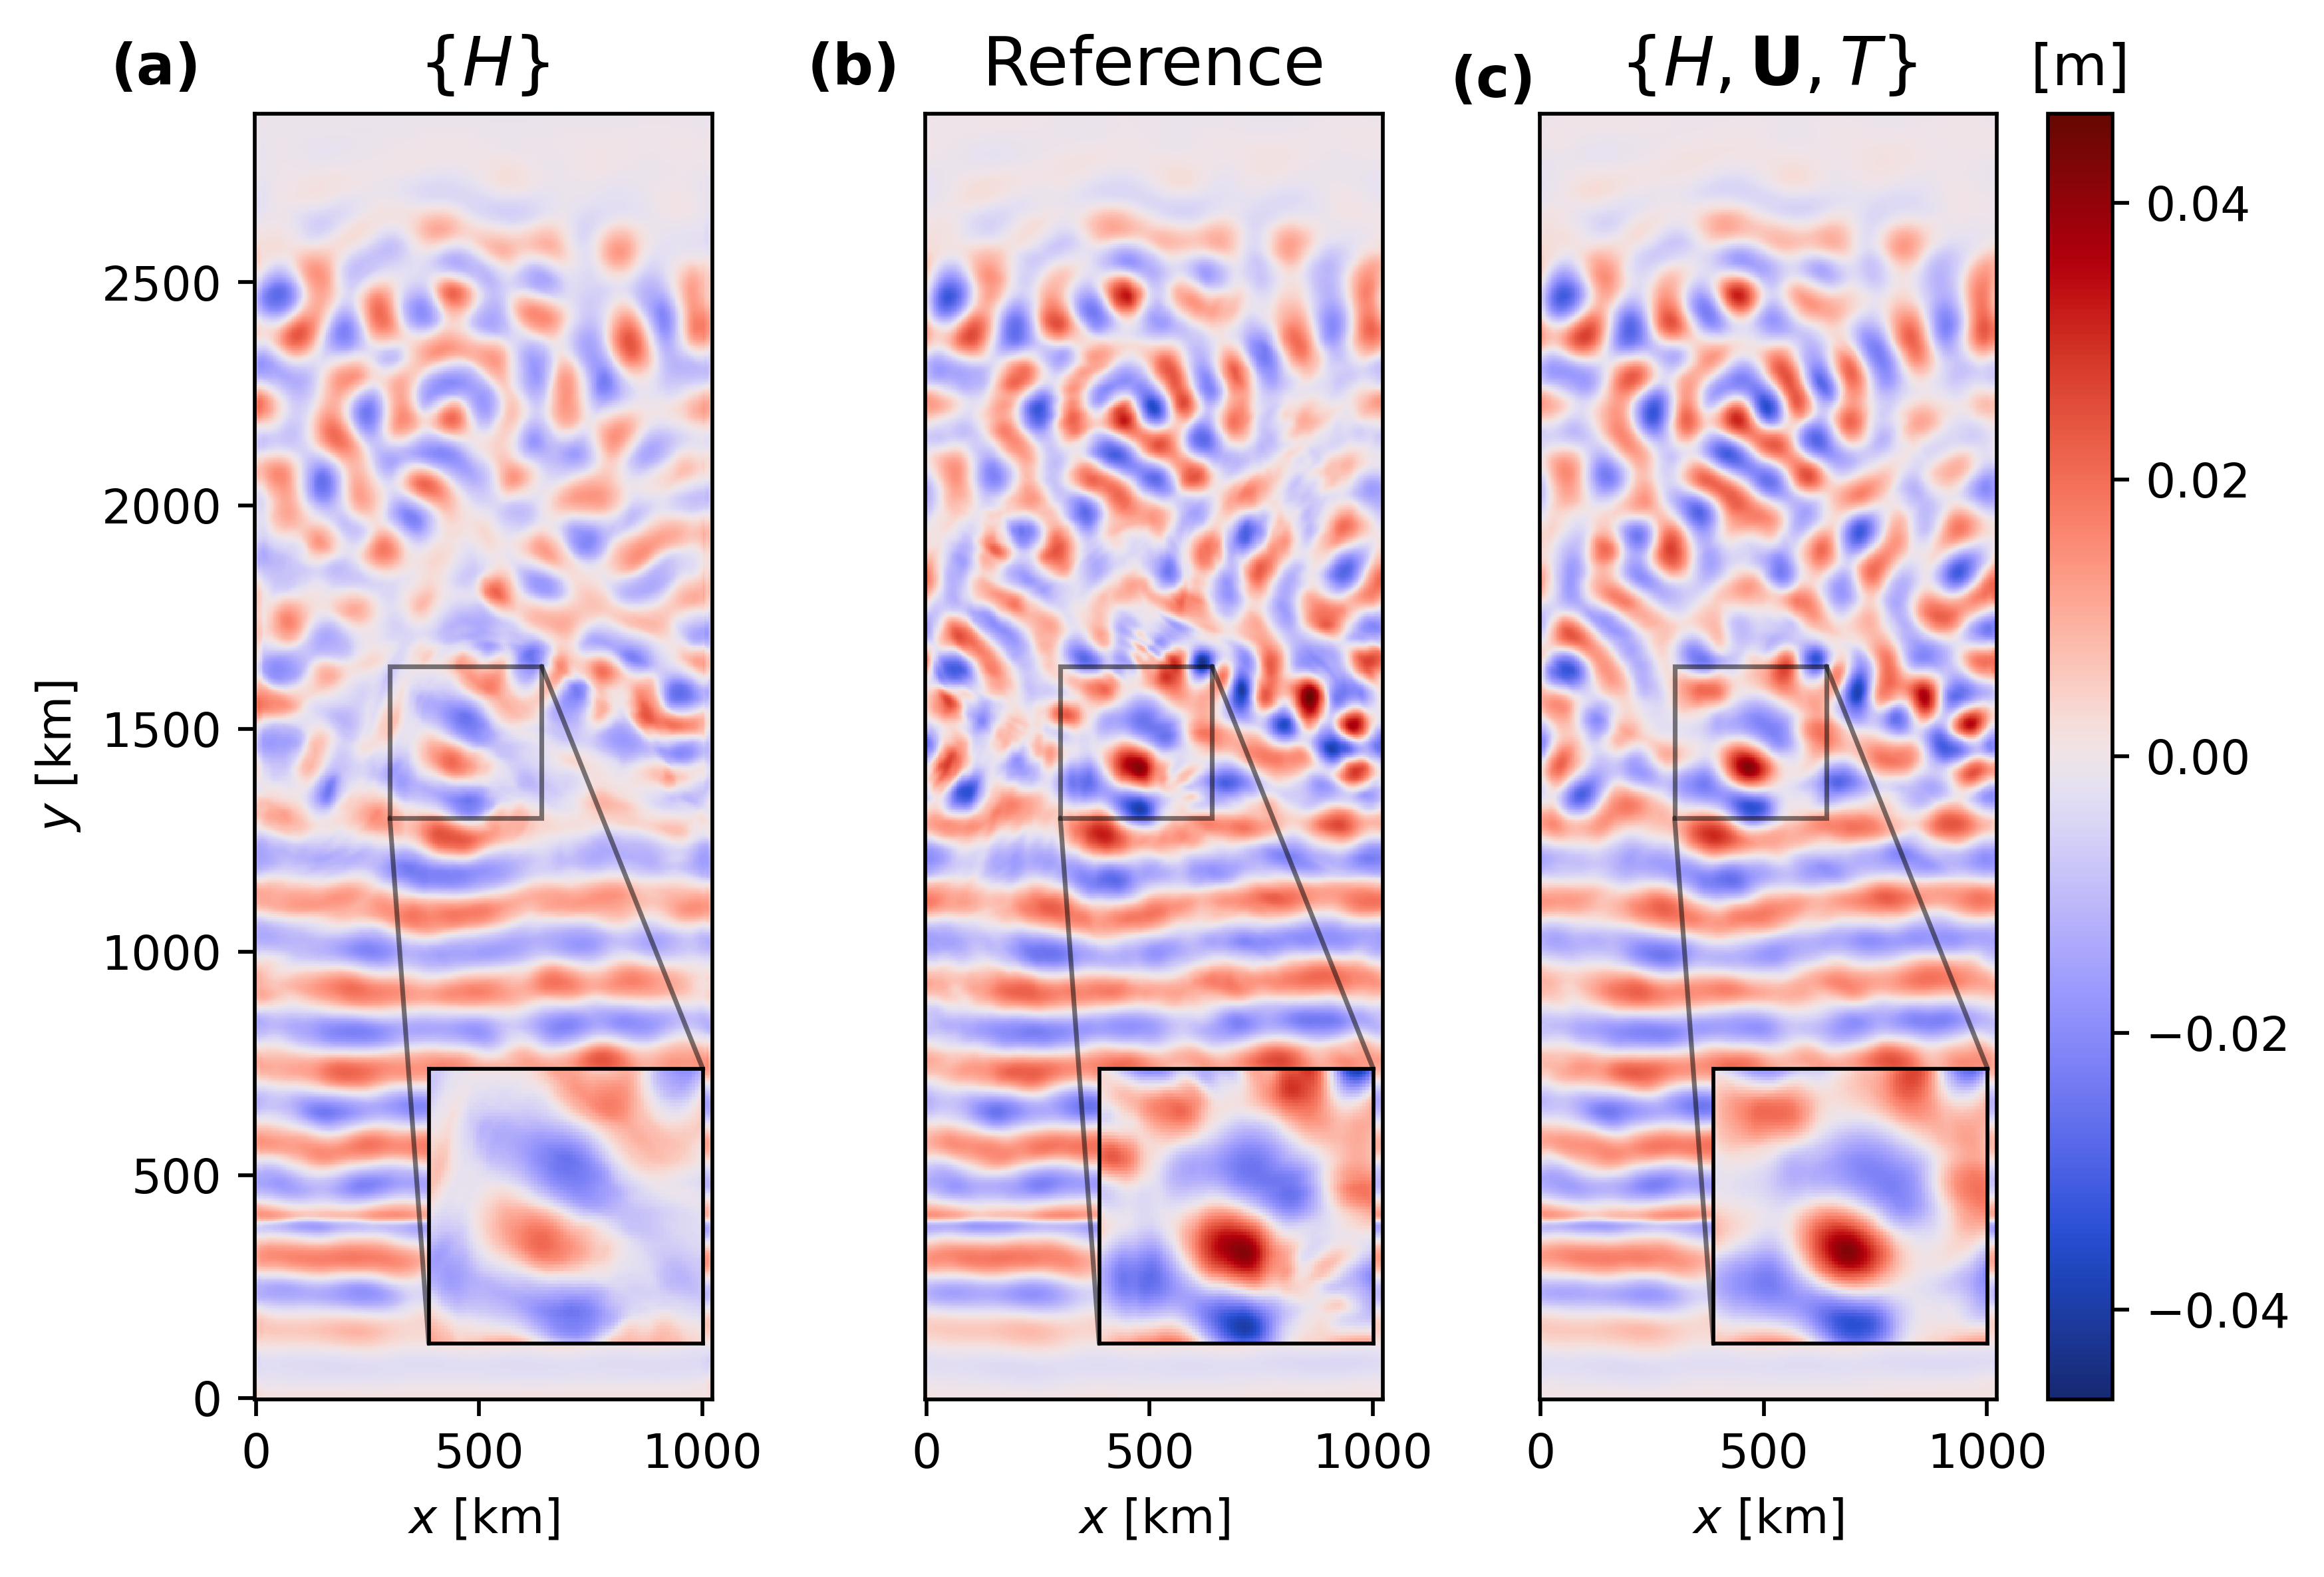

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (7.5,5))

fig.set_dpi(512)

im1 = ax1.pcolor(x_axis, y_axis, H_wave, cmap=ITssh_cmap, clim =ITclims)
ax1.set_title(r'$\{H\}$',fontsize ='x-large')
# fig.colorbar(im1, ax = ax1)

im2 = ax2.pcolor(x_axis, y_axis, true_wave, cmap=ITssh_cmap, clim =ITclims)
ax2.set_title('Reference',fontsize ='x-large')
# fig.colorbar(im2, ax = ax2)

ax2.get_yaxis().set_visible(False)

im3 = ax3.pcolor(x_axis, y_axis, HUT_wave, cmap=ITssh_cmap, clim =ITclims)
ax3.set_title(r'$\{H,\mathbf{U},T\}$',fontsize ='x-large')
cbar = fig.colorbar(im1, ax = ax3, pad=0.08)
ax3.get_yaxis().set_visible(False)

# rect_orig = (78, 65)
# rect_size = 80
zoom_x1, zoom_x2 = 75, 160  # Example coordinates for zoomed-in section
zoom_y1, zoom_y2 = 325, 410

extent = [zoom_x1, zoom_x2, zoom_y1, zoom_y2]
zoom_width = "70%"
x1, x2 = x_axis[zoom_x1], x_axis[zoom_x2]
y1, y2 = y_axis[zoom_y1], y_axis[zoom_y2]

inset_shape = [0.38, -0.15, 0.6, 0.6]
# | Coefficient | Meaning                          | Range         | Effect                                  |
# |-------------|----------------------------------|---------------|------------------------------------------|
# | left    | Horizontal start position        | 0 to 1        | 0 = left edge, 1 = right edge           |
# | bottom  | Vertical start position          | 0 to 1        | 0 = bottom edge, 1 = top edge           |
# | width   | Width of the inset axes          | 0 to 1        | as a fraction of parent axis width      |
# | height  | Height of the inset axes         | 0 to 1        | as a fraction of parent axis height     |


# For ax1
axins1 = ax1.inset_axes(inset_shape, xlim=(x1, x2), ylim=(y1, y2))
axins1.imshow(H_wave, origin='lower', cmap=ITssh_cmap, clim=ITclims,
              extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]])
axins1.set_xticks([])
axins1.set_yticks([])
ax1.indicate_inset_zoom(axins1, edgecolor="black")

# For ax2
axins2 = ax2.inset_axes(inset_shape, xlim=(x1, x2), ylim=(y1, y2))
axins2.imshow(true_wave, origin='lower', cmap=ITssh_cmap, clim=ITclims,
              extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]])
axins2.set_xticks([])
axins2.set_yticks([])
ax2.indicate_inset_zoom(axins2, edgecolor="black")

# For ax3
axins3 = ax3.inset_axes(inset_shape, xlim=(x1, x2), ylim=(y1, y2))
axins3.imshow(HUT_wave, origin='lower', cmap=ITssh_cmap, clim=ITclims,
              extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]])
axins3.set_xticks([])
axins3.set_yticks([])
ax3.indicate_inset_zoom(axins3, edgecolor="black")
ax1.set_xlabel(r'$x$ [km]') 
ax1.set_ylabel(r'$y$ [km]') 
ax2.set_xlabel(r'$x$ [km]') 
ax3.set_xlabel(r'$x$ [km]') 

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

labels = ['(a)', '(b)', '(c)']
axs = [ax1, ax2, ax3]

for i, ax in enumerate(axs):
    # Get axes position in figure coordinates
    pos = ax.get_position()
    x = pos.x0  # left of axis in figure coordinates
    y = pos.y1  # top of axis in figure coordinates
    
    # Add text slightly to left and above the axes (offset = 0.01)
    fig.text(x - 0.01, y + 0.01, labels[i], fontsize='large', fontweight='bold', va='bottom', ha='right')
cbar.ax.set_title('[m]', fontsize='large', pad=6)
# Decrease horizontal space:
fig.subplots_adjust(wspace=0.05)  # adjust as needed (default ~0.2-0.25)

plt.show()
fig.savefig(figfolder+'HUT_v_H.png', bbox_inches='tight',dpi=512)

0.8417875472460877
0.6627407693260108
0.8999855935949576
-0.09711399748800506
0.7913561333131433
0.8913021453095704
0.966888194222396


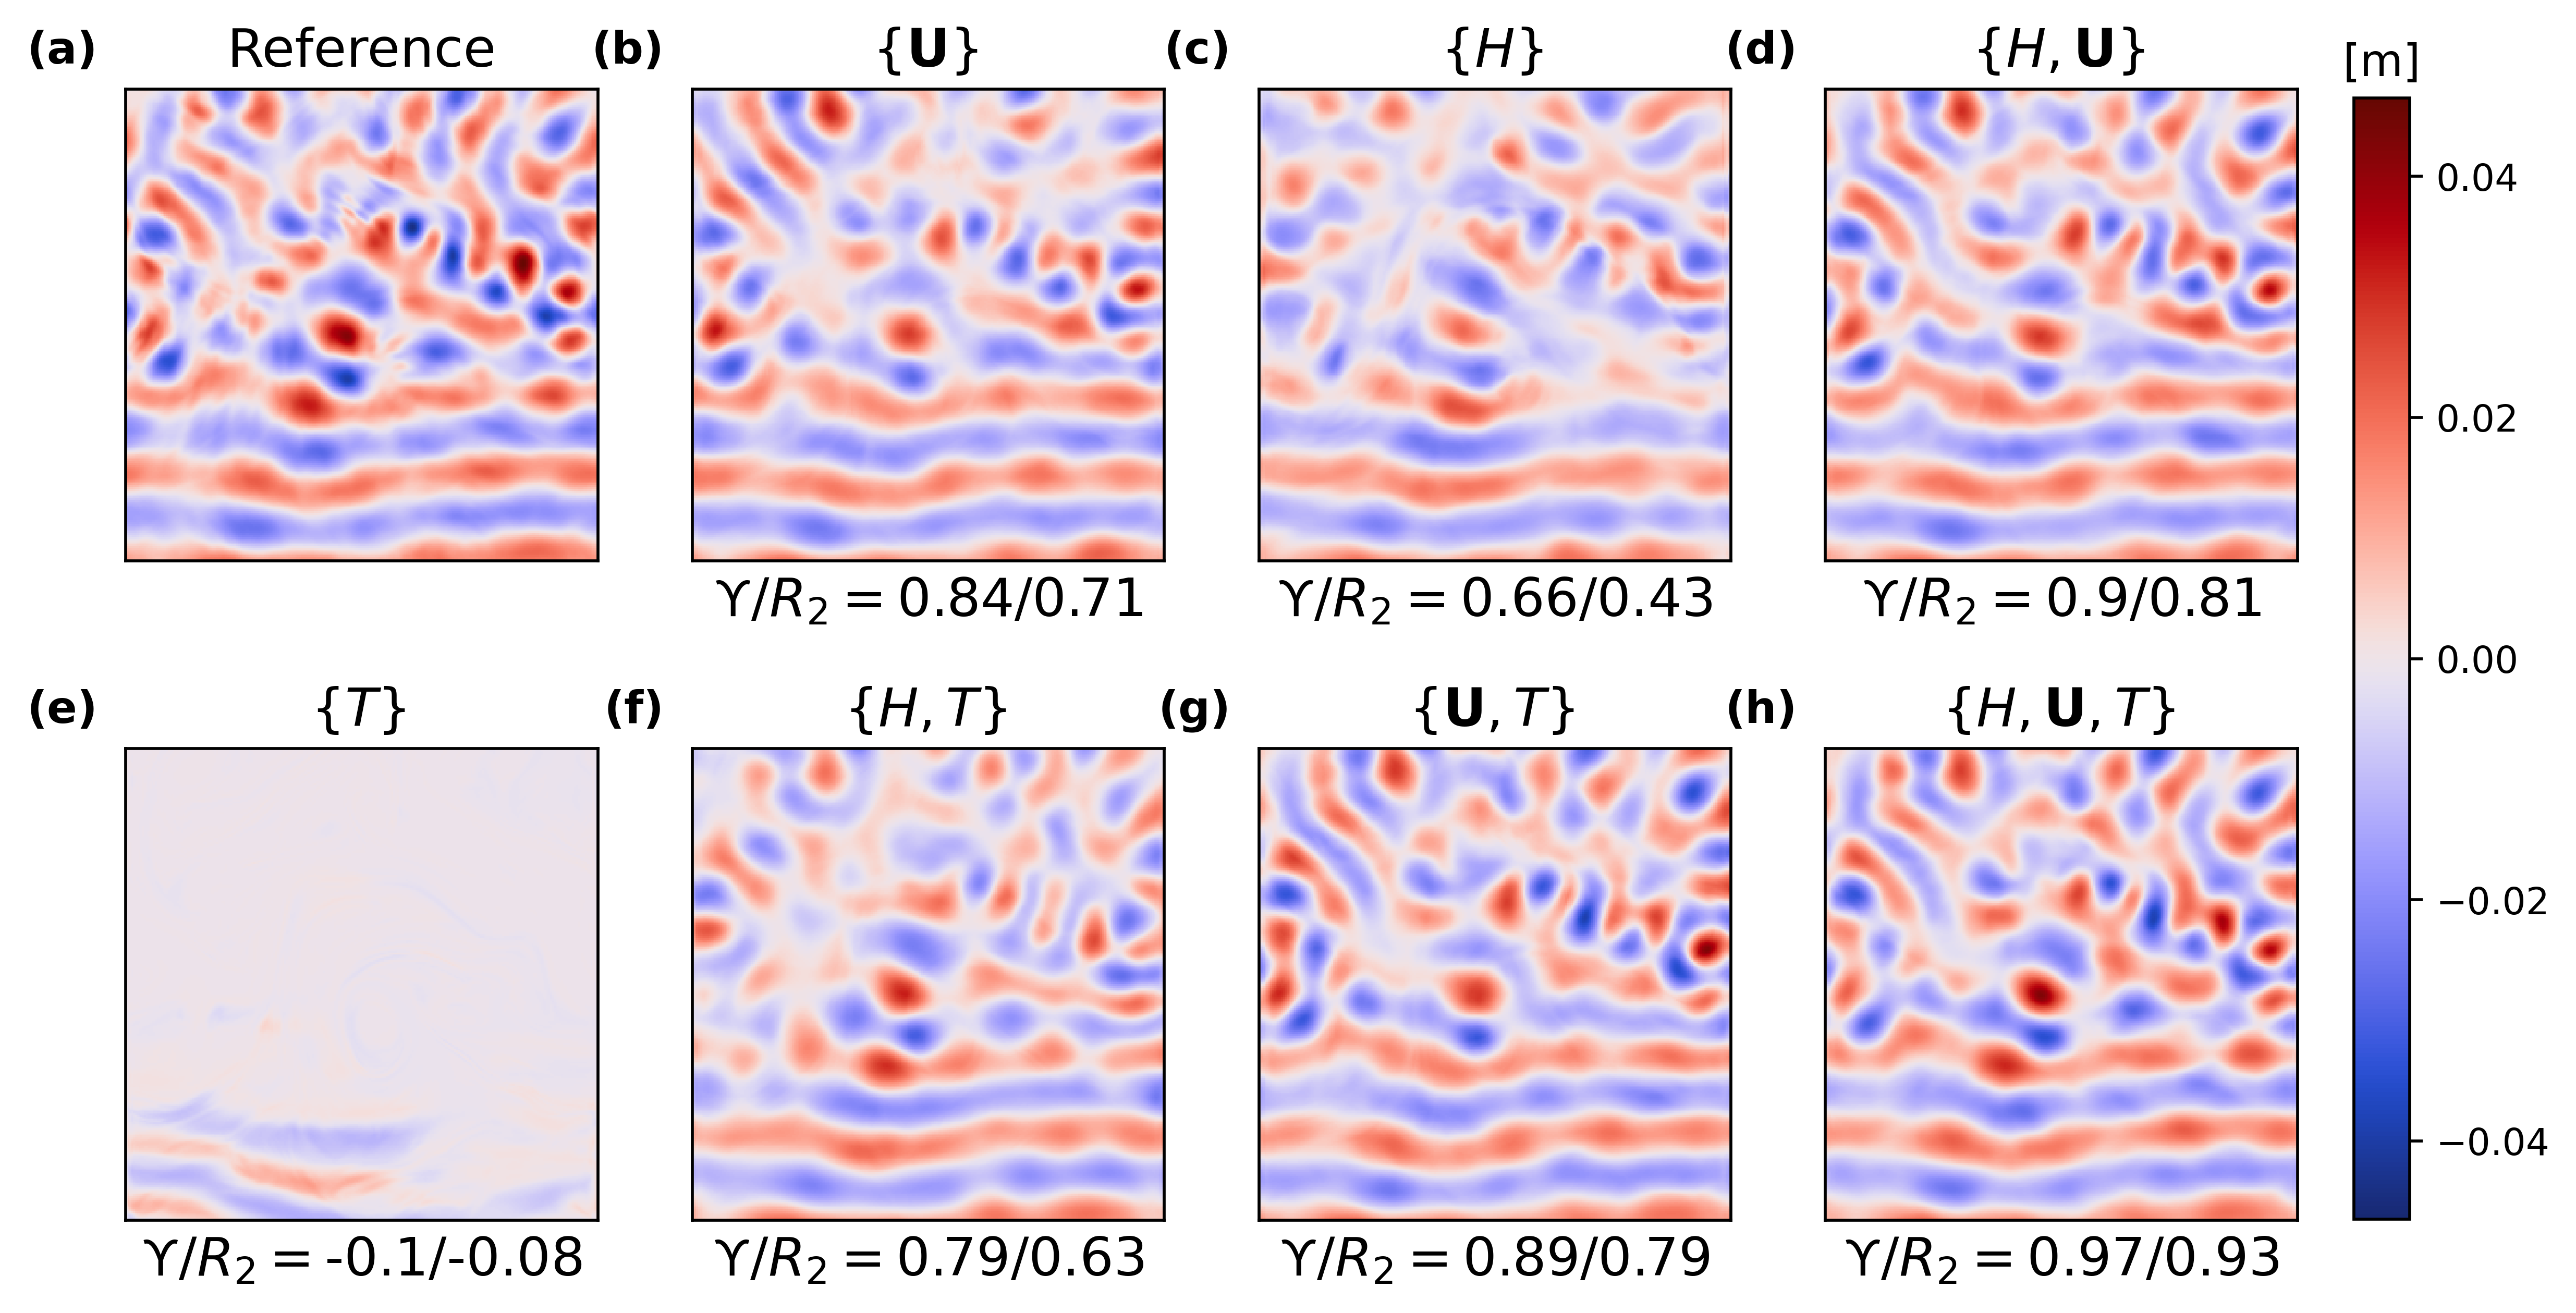

In [6]:
all_outputs = [U_out_mod, H_out_mod, HU_out_mod, T_out_mod, HT_out_mod,TU_out_mod, HUT_out_mod]
outputs_cosssh_HUTcomb =  np.stack([array[:, 0, :, :] for array in all_outputs], axis=0)
outputs_sinssh_HUTcomb =  np.stack([array[:, 1, :, :] for array in all_outputs], axis=0)


truth_snapshot = Truth_test[snap_index, 0]
model_ordering = [r'$\{\mathbf{U}\}$',r'$\{H\}$',r'$\{H, \mathbf{U}\}$',  r'$\{T\}$',  r'$\{H, T\}$',r'$\{\mathbf{U}, T\}$', r'$\{H, \mathbf{U}, T\}$']
fig=plt.figure(figsize = (10.5,6))
fig.set_dpi(512)
axes_list = []
for i in range(7):
    plt.subplot(2, 4,i+2)
    ax = plt.subplot(2, 4, i+2)  
    axes_list.append(ax)
    plt.imshow(outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :], origin ='lower', cmap = ITssh_cmap, clim =ITclims)

    correlation = corr(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
    coeff_determ = L2_R(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
    print (correlation)
#     plt.text(40, 20, r'$\mathcal{\Upsilon}$ = ' +  str(round(correlation, 2)), fontsize = 'x-large')
#     plt.text(40, 60, r'$R_2$ = ' +  str(round(coeff_determ, 2)), fontsize = 'x-large')
    plt.xlabel(r'$\mathcal{\Upsilon}/R_2 = $'+ str(round(correlation, 2))+'/'+str(round(coeff_determ, 2)),
               fontsize = 'x-large')
    plt.xticks([])
    plt.yticks([])

    plt.title('{} '.format(model_ordering[i]), fontsize = 'x-large')
plt.subplot(2,4,1)
im = plt.imshow(truth_snapshot[mid_slice, :] , origin ='lower', cmap = ITssh_cmap, clim =ITclims)
#plt.colorbar()
plt.title('Reference',  fontsize = 'x-large')
plt.xticks([])
plt.yticks([])
ax = plt.subplot(2, 4, 1)
axes_list.insert(0, ax)  # So that it's the first panel

# Create a single colorbar for the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.set_label('[m]', fontsize='x-large')  # Add title to the colorbar
cbar.ax.set_title('[m]', fontsize='large', pad=6)

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']  # extend to 8
for i, ax in enumerate(axes_list):
    pos = ax.get_position()
    x = pos.x0
    y = pos.y1
    fig.text(x - 0.01, y + 0.01, labels[i], fontsize='large', fontweight='bold', va='bottom', ha='right')
    

fig.savefig(figfolder+'gen_to_ssh.png', bbox_inches='tight',dpi=512)

In [7]:
# #power spectra using Gaussian window
# def make_gaussian_window_xy(x, y, sigma_fraction=1/6):
#     """
#     Creates a 2D Gaussian window for use in FFT-based spectral analysis.
    
#     Parameters:
#         x (1D array): x-axis grid (real-space), centered at 0.
#         y (1D array): y-axis grid (real-space), centered at 0.
#         sigma_fraction (float): Fraction of domain length used for Gaussian width (default 1/6).
        
#     Returns:
#         2D array: Gaussian window of shape (len(x), len(y)).
#     """
#     # Ensure x and y are centered at zero
#     if x[len(x)//2 - 1] != 0 or y[len(y)//2 - 1] != 0:
#         raise ValueError("x and y must be centered at 0 for the Gaussian window to work correctly.")
    
#     Lx = x[-1] - x[0] + (x[1] - x[0])
#     Ly = y[-1] - y[0] + (y[1] - y[0])
    
#     sigma_x = Lx * sigma_fraction
#     sigma_y = Ly * sigma_fraction
    
#     Y, X = np.meshgrid(y, x, indexing='ij')
#     gaussian_window = np.exp(-((X**2) / (2 * sigma_x**2) + (Y**2) / (2 * sigma_y**2)))
#     #gaussian_window = np.exp(-((Y**2) / (2 * sigma_y**2)))

#     return gaussian_window

#Borrowing Jeff's azimuthal averaging code
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    HW: it seems to work only when the grid spcaing of x and y are the same.
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:   
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1]) #hw: this only makes sense if the grid spacing of x and y are the same. 

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius #hw: : Finds the indices where the differences are non-zero, which correspond to locations where the radius value changes, effectively capturing the unique integer radius values.
    nr = rind[1:] - rind[:-1]        # number of radius bin 
#     print ('nr', nr)
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
    return radial_prof

def hwazimuthalAveAxis(image, dx):
    """
    Output the axis on which the output of azimuthalAverage is evaluated on. 
    Assuming that the axis spacing in the horizontal and vertical directions are the same.
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)
    r = np.hypot(x, y) #hw: this only makes sense if the grid spacing of x and y are the same. 

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    #i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius #hw: : Finds the indices where the differences are non-zero, which correspond to locations where the radius value changes, effectively capturing the unique integer radius values.

    redges = r_sorted[rind]
    ibincenters = (redges[1:]+redges[:-1])/2#bin centers of the azimuthal averages
    irout = ibincenters 
    rout = irout * dx
    return rout






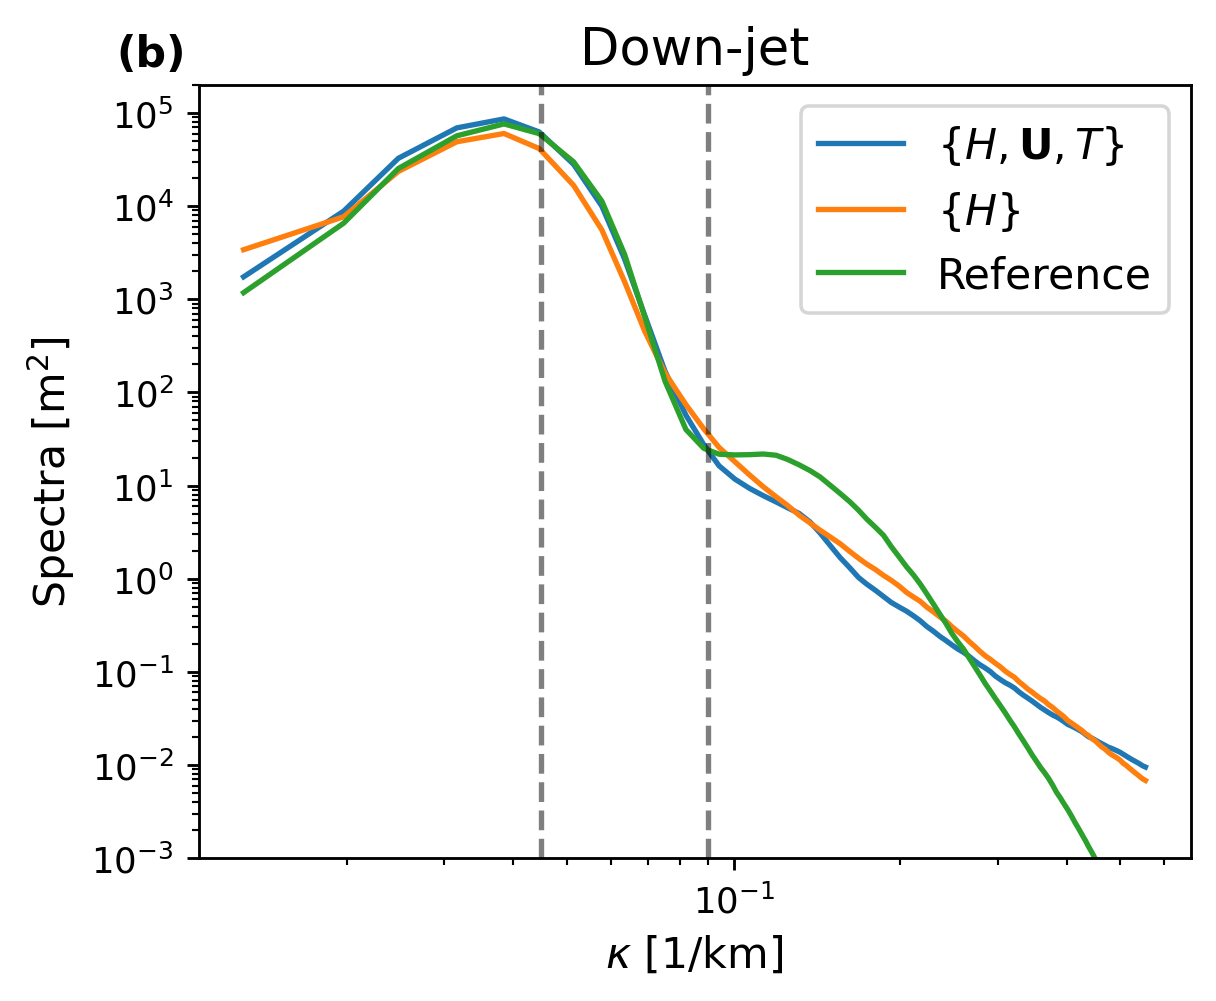

In [8]:
#cos SSH, for the down-jet panel
#number of grid points of wavenumbers k, l
#This version applies gaussian window in both x and y
#This is justified in that the periodic condition does not necessarily hold for the generated figures. 
nk = nx
nl = top_slice.stop - top_slice.start

#x and y axis in the real space, which are counterparts of wavenumbers k, l.
x = np.linspace(0,(nx-1)*dx,nk)
y = np.linspace(0,(nl-1)*dx,nl)
#Make them center at 0 (for hwffts to work)
x = x-x[nk//2-1]
y = y-y[nl//2-1]
Lx = nk*dx
Ly = nl*dx
#wavenumbers k,l
k=hwfft.k_of_x(x)
l=hwfft.k_of_x(y)

#Hanning window in both x and y
#This is sloppily written, I haven't improved this 
#only works if nk=nl as is, although it can be modified for cases where nk is not equal to nl.
if nk != nl:
    raise ValueError(f"The variable 'nk' ({nk}) is not equal to 'nl' ({nl}). The Hanning window currently doesn't adapt for this case.")
Nk = nk
#The following doesn't consider cases when (xhann, yhann) = (1,0). We don't need these cases yet. 
hanning_1=np.hanning(Nk)
hanning_2D_xy=np.tile(hanning_1,(Nk,1))
hanning_2D_xy=hanning_2D_xy.transpose()
hanning_2D_xy=hanning_2D_xy*np.tile(hanning_1,(Nk,1))

#gaussian_window_xy = make_gaussian_window_xy(x, y)

S_HUT=np.zeros((nk,nl)) #2D power spectra
S_H=np.zeros((nk,nl))              
S_truth=np.zeros((nk,nl))               
Scross_HUT = np.zeros((nk,nl))  #2D cross spectra between tar and fak

#Power spectra of output ssh_cos based on all the last 100 snapshots.
itstart = -1-100
itend = -1
ncount = 0
for it in np.arange(itstart,itend):
    ncount = ncount + 1
    ssh_HUT_windowed = HUT_out_mod[it,0,top_slice,:] * hanning_2D_xy #looking at ssh_cos 
    ssh_H_windowed = H_out_mod[it,0,top_slice,:] * hanning_2D_xy 
    ssh_truth_windowed = Truth_test[it,0,top_slice,:] * hanning_2D_xy 
    
    ssh_truth_kl=hwfft.hwfft2(x,y,ssh_truth_windowed)
    S_truth=S_truth+np.real(ssh_truth_kl*np.conjugate(ssh_truth_kl))/(Lx*Ly)

    ssh_HUT_kl=hwfft.hwfft2(x,y,ssh_HUT_windowed)
    S_HUT=S_HUT+np.real(ssh_HUT_kl*np.conjugate(ssh_HUT_kl))/(Lx*Ly)
    
    ssh_H_kl=hwfft.hwfft2(x,y,ssh_H_windowed)
    S_H=S_H+np.real(ssh_H_kl*np.conjugate(ssh_H_kl))/(Lx*Ly)
    
    Scross_HUT=Scross_HUT+ssh_truth_kl*np.conjugate(ssh_HUT_kl)/(Lx*Ly)

S_truth=S_truth/ncount
S_HUT=S_HUT/ncount
S_H=S_H/ncount
Scross_HUT=Scross_HUT/ncount

#This is squared coherence
Coh=((np.absolute(Scross_HUT))**2)/S_HUT/S_truth

#Now we compute the azimuthal averages of the 2D spectra; i.e., we compute the average of them, which are functions of (k,l), as functions of \sqrt{k^2+l^2}, averaged over narrow rings in \sqrt{k^2+l^2}

S_truth_m0=azimuthalAverage(S_truth)
S_HUT_m0=azimuthalAverage(S_HUT)
S_H_m0=azimuthalAverage(S_H)


dk = k[1]-k[0]
kappa =  hwazimuthalAveAxis(S_H, dk)
#incoming wavenumber
kappain = 2*np.pi/(140000)#This is read at around y=180 km

fig1,axs1=plt.subplots(figsize=(5,4))
fig1.set_dpi(256)
axs1.loglog(kappa[1:iplotend]*1000,(S_HUT_m0[1:iplotend]),label=r'$\{H,\mathbf{U},T\}$', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_H_m0[1:iplotend]),label=r'$\{H\}$', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_truth_m0[1:iplotend]),label='Reference', linewidth=1.5)
axs1.legend(fontsize='large') 
plt.axvline(x=kappain*1000, c='k', linestyle='--', alpha = 0.5) #, label =r'$x = 2 K_i$'
plt.axvline(x=kappain*1000*2, c='k', linestyle='--', alpha = 0.5) #, label =r'$x = 2 K_i$'
axs1.set_ylim([0.001, 2*10**5])
axs1.set_xlabel(r'$\kappa$ [1/km]', fontsize='large')
axs1.set_ylabel(r'Spectra [m$^2$]', fontsize='large')


# Get axes position in figure coordinates
pos = axs1.get_position()
x = pos.x0  # left of axis in figure coordinates
y = pos.y1  # top of axis in figure coordinates
# Add text slightly to left and above the axes 
fig1.text(x-0.01, y+0.01, '(b)', fontsize='large', fontweight='bold', va='bottom', ha='right')
axs1.set_title(r'Down-jet',fontsize ='x-large')


fig1.savefig(figfolder+'spectrum_comparison_trunc_downjet.png', bbox_inches='tight',dpi = 256)

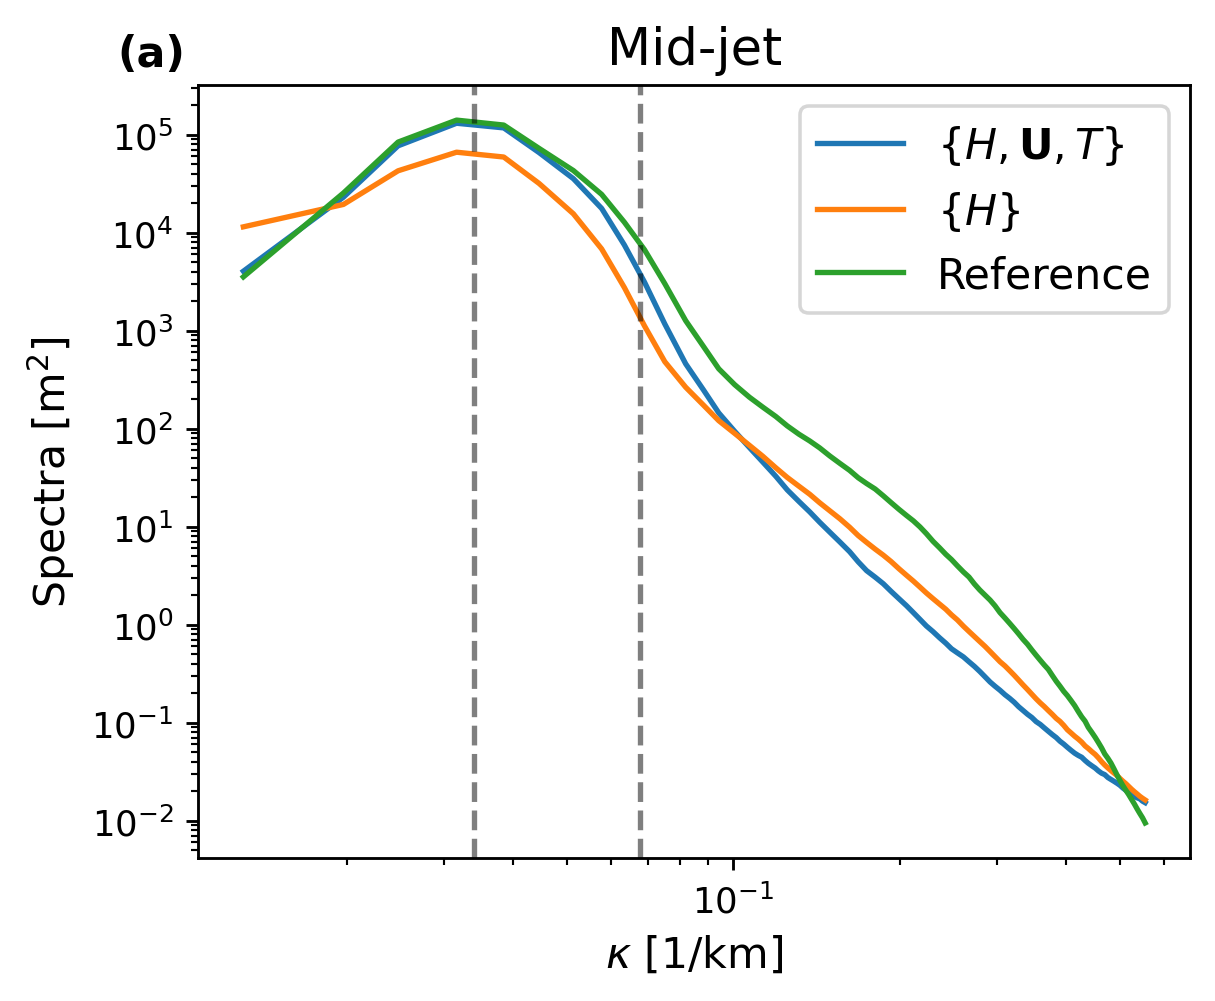

In [9]:
#cos SSH, mid-jet panel
#number of grid points of wavenumbers k, l
nk = nx
nl = mid_slice.stop - mid_slice.start

#x and y axis in the real space, which are counterparts of wavenumbers k, l.
x = np.linspace(0,(nx-1)*dx,nk)
y = np.linspace(0,(nl-1)*dx,nl)
#Make them center at 0 (for hwffts to work)
x = x-x[nk//2-1]
y = y-y[nl//2-1]
Lx = nk*dx
Ly = nl*dx
#wavenumbers k,l
k=hwfft.k_of_x(x)
l=hwfft.k_of_x(y)

#looking at mid-jet panels only 
S_HUT=np.zeros((nk,nl)) #2D power spectra
S_H=np.zeros((nk,nl))              
S_truth=np.zeros((nk,nl))               
Scross_HUT = np.zeros((nk,nl))  #2D cross spectra between tar and fak


#Power spectra of output ssh_cos based on all the last 100 snapshots.
itstart = -1-100
itend = -1
ncount = 0
for it in np.arange(itstart,itend):
    ncount = ncount + 1
    ssh_HUT_windowed = HUT_out_mod[it,0,mid_slice,:] * hanning_2D_xy #looking at ssh_cos 
    ssh_H_windowed = H_out_mod[it,0,mid_slice,:] * hanning_2D_xy 
    ssh_truth_windowed = Truth_test[it,0,mid_slice,:] * hanning_2D_xy 
    
    ssh_truth_kl=hwfft.hwfft2(x,y,ssh_truth_windowed)
    S_truth=S_truth+np.real(ssh_truth_kl*np.conjugate(ssh_truth_kl))/(Lx*Ly)

    ssh_HUT_kl=hwfft.hwfft2(x,y,ssh_HUT_windowed)
    S_HUT=S_HUT+np.real(ssh_HUT_kl*np.conjugate(ssh_HUT_kl))/(Lx*Ly)
    
    ssh_H_kl=hwfft.hwfft2(x,y,ssh_H_windowed)
    S_H=S_H+np.real(ssh_H_kl*np.conjugate(ssh_H_kl))/(Lx*Ly)
    
    Scross_HUT=Scross_HUT+ssh_truth_kl*np.conjugate(ssh_HUT_kl)/(Lx*Ly)

S_truth=S_truth/ncount
S_HUT=S_HUT/ncount
S_H=S_H/ncount
Scross_HUT=Scross_HUT/ncount

#This is squared coherence
Coh=((np.absolute(Scross_HUT))**2)/S_HUT/S_truth

#Now we compute the azimuthal averages of the 2D spectra; i.e., we compute the average of them, which are functions of (k,l), as functions of \sqrt{k^2+l^2}, averaged over narrow rings in \sqrt{k^2+l^2}

# #This is a method that simply does the averaging numerically. This is more popularly used. 
# S_truth_m0=m0.m0_savage(k,l,S_truth,kappa)
# S_HUT_m0=m0.m0_savage(k,l,S_HUT,kappa)
# S_H_m0=m0.m0_savage(k,l,S_H,kappa)

S_truth_m0=azimuthalAverage(S_truth)
S_HUT_m0=azimuthalAverage(S_HUT)
S_H_m0=azimuthalAverage(S_H)

dk = k[1]-k[0]
kappa =  hwazimuthalAveAxis(S_H, dk)
#incoming wavenumber
kappain = 2*np.pi/(185000)#This is read at around y=1000 km
#kappain = 2*np.pi/(167000)

fig1,axs1=plt.subplots(figsize=(5,4))
fig1.set_dpi(256)
axs1.loglog(kappa[1:iplotend]*1000,(S_HUT_m0[1:iplotend]),label=r'$\{H,\mathbf{U},T\}$', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_H_m0[1:iplotend]),label=r'$\{H\}$', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_truth_m0[1:iplotend]),label='Reference', linewidth=1.5)
axs1.legend(fontsize='large')
plt.axvline(x=kappain*1000, c='k', linestyle='--', alpha = 0.5) #, label =r'$x = 2 K_i$'
plt.axvline(x=kappain*1000*2, c='k', linestyle='--', alpha = 0.5) #, label =r'$x = 2 K_i$'


# Get axes position in figure coordinates
pos = axs1.get_position()
x = pos.x0  # left of axis in figure coordinates
y = pos.y1  # top of axis in figure coordinates
# Add text slightly to left and above the axes 
fig1.text(x-0.01, y+0.01, '(a)', fontsize='large', fontweight='bold', va='bottom', ha='right')
axs1.set_title(r'Mid-jet',fontsize ='x-large')

axs1.set_xlabel(r'$\kappa$ [1/km]', fontsize='large')
axs1.set_ylabel(r'Spectra [m$^2$]', fontsize='large')


fig1.savefig(figfolder+'spectrum_comparison_trunc_midjet.png', bbox_inches='tight',dpi = 256)

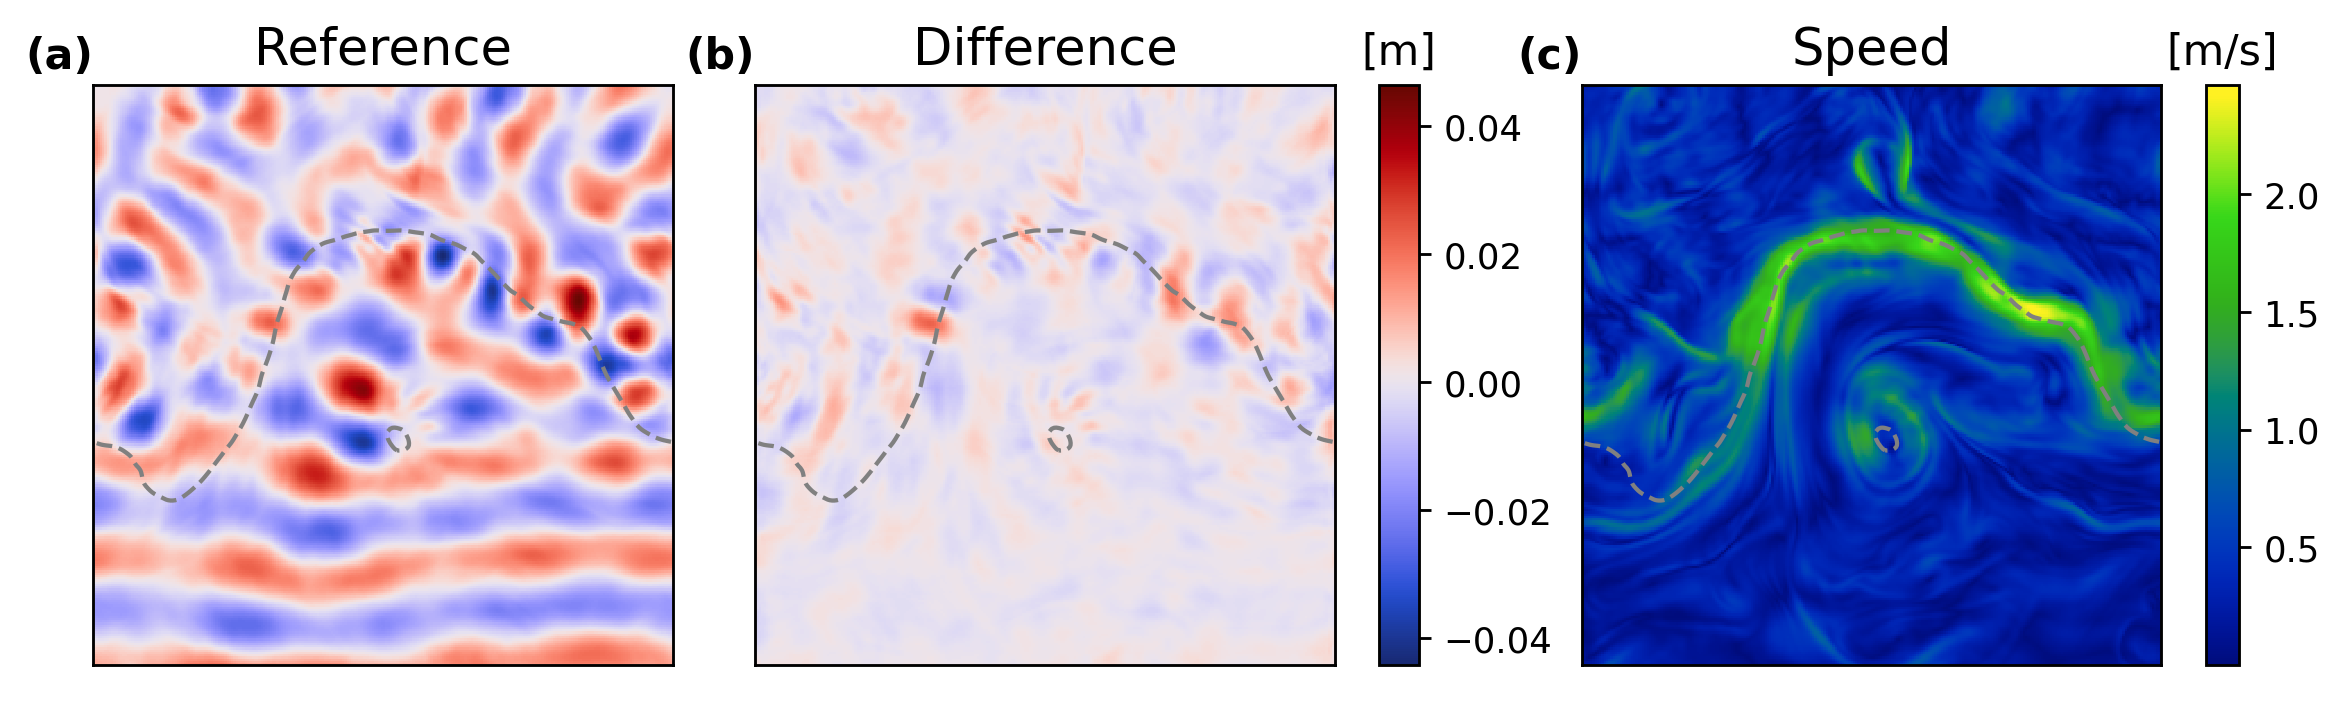

In [10]:
#Figure comparing the error snapshot and speed 

#Load testing files to get H, U (using existing functions, not very resource efficient but does the job)
import helper_functions as hf
root_dir = '../data/'
nctrains, nctest = hf.load_data_from_nc_as_lists(root_dir)
Ntest=150
def preload_data(nctrains, total_records):
    #total_records = Ntrain#sum(nc.dimensions['time_counter'].size for nc in nctrains)
    #dimensions of data of the nc file.
    max_height = 722
    max_width = 258
    all_input_data = np.zeros((total_records, N_inp, max_height, max_width))*np.nan
    all_output_data = np.zeros((total_records, N_out, max_height, max_width))*np.nan
    current_index = 0
    for ncindex, ncdata in enumerate(nctrains):
        num_recs = ncdata.dimensions['time_counter'].size
        rec_slice = slice(current_index, current_index + num_recs)
        
        for ind, var_name in enumerate(var_input_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            # print('data_slice shape:')
            # print(data_slice.shape)        
            #all_input_data[rec_slice, ind, :, :] = data_slice
            #For some variables, the dimensions in (x, y) may be smaller than (max_height, max_width). Changing the code so that it adapts them.
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_input_data[rec_slice, ind, :slice_height, :slice_width] = data_slice
    

        for ind, var_name in enumerate(var_output_names):
            data_slice = np.squeeze(ncdata.variables[var_name])
            #all_output_data[rec_slice, ind, :, :] = data_slice
            # Get the actual dimensions of data_slice
            slice_height, slice_width = data_slice.shape[-2], data_slice.shape[-1]
            # Place data_slice into the corresponding slice of all_input_data
            all_output_data[rec_slice, ind, :slice_height, :slice_width] = data_slice

        current_index += num_recs
        
    return all_input_data, all_output_data

#Load test data as one single batch
def loaddata_preloaded_test(all_input_data, all_output_data):
    #rec_slice = slice(index, index + batch_size)
    lim = 720
    width = 256
    yslice = slice(0, lim)
    xslice = slice(0, width)
    # print('rec_slice is:')
    # print(rec_slice)
    # print('mean of squared values of loaded input data:')
    # print("{0:0.32f}".format(np.nanmean(all_input_data[rec_slice, :, yslice, xslice]**2)))
    return (all_input_data[:, :, yslice, xslice], 
            all_output_data[:, :, yslice, xslice])

vi1 = 'ssh_ins'
vi2 = 'T_xy_ins'
vi3 = 'u_xy_ins'
vi4 = 'v_xy_ins'
vo1 = 'ssh_cos'
var_input_names = [vi1, vi2, vi3, vi4]
var_output_names = [vo1]

N_inp = len(var_input_names)
N_out = len(var_output_names)

all_test_input, all_test_output = preload_data(nctest, Ntest)

inpH_sample = all_test_input[snap_index,0,mid_slice,1:-1]
inpU_sample = all_test_input[snap_index,2,mid_slice,1:-1]
inpV_sample = all_test_input[snap_index,3,mid_slice,1:-1]
outTruth_sample = all_test_output[snap_index,0,mid_slice,1:-1]
outHUT_sample = HUT_out_mod[snap_index,0,mid_slice,:]

ITclims = (np.min(outTruth_sample), np.max(outTruth_sample))
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(11, 3),dpi=256)
# - Columns 0, 1, 4: Your image panels.
# - Column 2: Colorbar for first two panels.
# - Column 3: Just a gap! Its width is controlled by the relative value in `width_ratios`.
# - Column 5: Colorbar for the third panel.
# width_ratios: [panel0, panel1, cbar12, gap, panel2, cbar3]
gs = gridspec.GridSpec(
    1, 6, width_ratios=[1, 1, 0.06, 0.17, 1, 0.05], wspace=0.02  # tiny wspace, we control gaps via columns!
)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 4])

cmapmagfactor=1
ITclims = (np.min(outTruth_sample)*cmapmagfactor, np.max(outTruth_sample)*cmapmagfactor)

im0 = ax0.pcolor(outTruth_sample, cmap=ITssh_cmap, clim=ITclims)
im1 = ax1.pcolor(outTruth_sample-outHUT_sample, cmap=ITssh_cmap, clim=ITclims)
im2 = ax2.pcolor(np.sqrt(inpU_sample**2 + inpV_sample**2), cmap=cc.cm.linear_bgy_10_95_c74)

for a in [ax0, ax1, ax2]:
    a.set_aspect(1)
    a.set_xticks([])
    a.set_yticks([])

ax0.set_title('Reference', fontsize='x-large')
ax1.set_title('Difference', fontsize='x-large')
ax2.set_title('Speed', fontsize='x-large')

# Colorbars
cax12 = fig.add_subplot(gs[0, 2])
cb1 = fig.colorbar(im0, cax=cax12)

cax3 = fig.add_subplot(gs[0, 5])
cb2 = fig.colorbar(im2, cax=cax3)

# Optional: Hide the gap axis (if you want it entirely invisible)
ax_gap = fig.add_subplot(gs[0, 3])
ax_gap.axis('off')

for a in [ax0, ax1, ax2]:
    a.contour(inpH_sample, levels=[0], colors='gray', linewidths=1.2,linestyles='--')
    


labels = ['(a)', '(b)', '(c)']
axs = [ax0, ax1, ax2]
for i, ax in enumerate(axs):
    # Get axes position in figure coordinates
    pos = ax.get_position()
    x = pos.x0  # left of axis in figure coordinates
    y = pos.y1  # top of axis in figure coordinates   
    # Add text slightly to left and above the axes
    fig.text(x, y + 0.01, labels[i], fontsize='large', fontweight='bold', va='bottom', ha='right')
    
cb1.ax.set_title('[m]', fontsize='large', pad=6)
cb2.ax.set_title('[m/s]', fontsize='large', pad=6)



fig.savefig(figfolder+'difference_vs_speed.png', bbox_inches='tight',dpi=256)